# BIBLIOTECAS

In [7]:
# =============================
# script para testes

# Made by: Lucas da Silva Menezes
# 31/07/2023
# =============================

# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt

# import locais
from Scripts.calc import *
import Scripts.cooling_rate as cooling_rate

**Funções**

In [34]:
def read_profile(file_path, nlevs = None):
	# lendo o arquivo do perfil tropical
	df = pd.read_csv(
		file_path,
		sep = ',',
		converters = dict(
			pres = lambda x: pd.to_numeric(x, errors = 'coerce'),
			air_density = lambda x: pd.to_numeric(x, errors = 'coerce'),
			water_density = lambda x: pd.to_numeric(x, errors = 'coerce'),
			ozone_density = lambda x: pd.to_numeric(x, errors = 'coerce')
		)
	)

	# COLUNA | UNIDADE | DESCRICAO
	# hght | km | altitude
	# pres | mb | Pressão atmosférica
	# temp | K | Temperatura do ar
	# air_density | g / m³ | Densidade da parcela de ar úmido
	# water_density | g / m³ | Densidade do vapor d'água na parcela
	# ozone_density | g / m³ | Densidade do ozonio na parcela

	# Se especificado, interpola para nlevs
	if nlevs is not None:
		# New levels
		z = df['hght'].values
		new_z = np.linspace(z[0], z[-1], nlevs)
		new_df = {}

		# Interp
		new_df['hght'] = new_z
		for j in range(1, df.columns.shape[0]):
			col = df.columns[j]
			new_df[col] = np.interp(new_z, z, df[col])

		# create new df
		df = pd.DataFrame.from_dict(new_df)

	# Calcula a razao de mistura | Adimensional
	df['mixr'] = df['water_density'] / (df["air_density"] - df['water_density'])

	# Converte a altitude de [km] para [m]
	df['hght'] *= 1e3
	
	return df

def read_wyoming_excel(file_path, sheet = 0):
	# Nome de cada coluna no arquivo da sondagem (Wyoming)
	cols = [
		'pres', # Pressão atmosférica em hPa
		'hght', # Altitude em metros
		'temp', # Temperatura do ar [°C]
		'dwpt', # Temperatura do ponto de orvalho em [°C]
	]

	# lendo o arquivo do perfil atmosférico (Wyoming)
	df = pd.read_excel(
		file_path,
		sheet_name = sheet,
		header = None,
		names = cols)

	# Converte tempratura e temperatura do ponto de orvalho para Kelvin
	df['temp'] += 273.15
	df['dwpt'] += 273.15

	# Calcula a razão de mistura
	df['mixr'] = mixing_ratio_from_dewpoint_pressure(df['dwpt'], df['pres'])

	# Calcula a densidade d'agua [Kg / m³]
	df['water_density'] = density_water_vapor(df['temp'].values, df['dwpt'].values)

	return df


In [15]:
df = read_profile(r".\Dados\tropical.csv", nlevs = 100)
df

,hght,pres,temp,air_density,water_density,ozone_density,mixr
0,0.000000,1013.000000,300.000000,1167.000000,19.000000,0.000056,0.016551
1,454.545455,963.454545,297.272727,1120.181818,16.272727,0.000056,0.014741
2,909.090909,913.909091,294.545455,1073.363636,13.545455,0.000056,0.012781
3,1363.636364,868.000000,291.818182,1029.418182,11.654545,0.000055,0.011451
4,1818.181818,823.000000,289.090909,986.190909,9.972727,0.000054,0.010216
...,...,...,...,...,...,...,...
95,43181.818182,2.120909,261.000000,2.854818,0.000028,0.000023,0.000010
96,43636.363636,1.988182,262.000000,2.665364,0.000026,0.000021,0.000010
97,44090.909091,1.855455,263.000000,2.475909,0.000023,0.000018,0.000009
98,44545.454545,1.722727,264.000000,2.286455,0.000021,0.000016,0.000009


**Cooling rate (sem nuvens)**

In [16]:
# ------------- SIGLAS -------------
# cr = cooling rate

# nc = no clouds

# rot = rotational
# cont = continuum
# vib = vibrational
# all =  all bands (rot + cont + vib)

modelo = cooling_rate.CoolingRate(
    T = df['temp'].values,
    q = df['mixr'].values,
    p = df['pres'].values,
    Qv = df['water_density'].values * 1e-3, # [kg / m^3]
    z = df['hght'].values
    ) 

# Taxa de resfriamento [K / day]
df['cr_nc_rot'] = modelo.clear_sky(band = 'rot')
df['cr_nc_cont'] = modelo.clear_sky(band = 'cont')
df['cr_nc_vib'] = modelo.clear_sky(band = 'vib')
df['cr_nc_all'] = modelo.clear_sky(band = 'all')

**Figura**

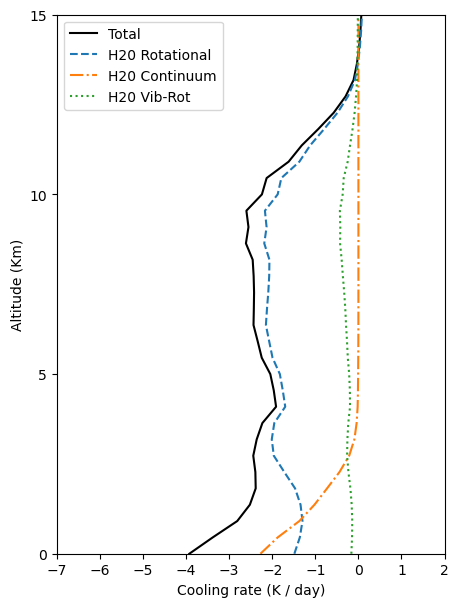

In [17]:
fig, ax  = plt.subplots(figsize = (5, 7))

ax.plot(df['cr_nc_all'], df['hght'] * 1e-3, linestyle = 'solid', color = 'k', label = 'Total')
ax.plot(df['cr_nc_rot'], df['hght'] * 1e-3, linestyle =  'dashed', label = 'H20 Rotational')
ax.plot(df['cr_nc_cont'], df['hght'] * 1e-3, linestyle = 'dashdot', label = 'H20 Continuum')
ax.plot(df['cr_nc_vib'], df['hght'] * 1e-3, linestyle = 'dotted', label = 'H20 Vib-Rot')

# Eixo Y
ax.set_ylim(0, 15)
ax.set_yticks([0, 5, 10, 15])

# Eixo X
left, right = ax.get_xlim()
ax.set_xticks(np.arange(-20, 20, 1))
ax.set_xlim(-7, 2)

# Textos
ax.set_ylabel("Altitude (Km)")
ax.set_xlabel("Cooling rate (K / day)")

# Legenda
plt.legend()

plt.show()

**Cooling rate (com nuvem)**

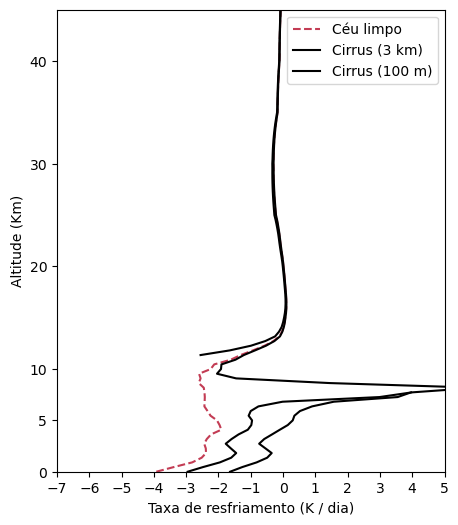

In [18]:
# ------------- SIGLAS -------------
# cr = cooling rate
# all =  all bands (rot + cont + vib)

# Taxa de resfriamento [K / day]
df['cirrus_3km'] = modelo.cloudy_atmosphere(
	band = 'all', # Todas as bandas
	Ecb = 0.9876, # Emissividade da base da nuvem
	Ect = 0.9876, # Emissividade do topo da nuvem
	Rc = 0.2401, # Refletividade da nuvem
	Tc = 0, # Transmissividade da nuvem
	Zcb = 8000, # Indice (nivel) na sondagem onde a base da nuvem esta
	Zct= 11000, # Indice (nivel) na sondagem onde o topo da nuvem esta
	)

df['cirrus_100m'] = modelo.cloudy_atmosphere(
	band = 'all', # Todas as bandas
	Ecb = 0.4488, # Emissividade da base da nuvem
	Ect = 0.4488, # Emissividade do topo da nuvem
	Rc = 0.0679, # Refletividade da nuvem
	Tc = 0.5594, # Transmissividade da nuvem
	Zcb = 8000, # Indice (nivel) na sondagem onde a base da nuvem esta
	Zct= 8100, # Indice (nivel) na sondagem onde o topo da nuvem esta
	)

# Figura
fig, ax  = plt.subplots(figsize = (5, 6))

ax.plot(df['cr_nc_all'], df['hght'] * 1e-3, '--', color = '#C33C54', label = 'Céu limpo')
ax.plot(df['cirrus_3km'], df['hght'] * 1e-3, '-', color = 'k', label = 'Cirrus (3 km)')
ax.plot(df['cirrus_100m'], df['hght'] * 1e-3, '-', color = 'k', label = 'Cirrus (100 m)')


# Eixo Y
ax.set_yticks([0, 5, 10, 20, 30, 40])
ax.set_ylim(0, 45)

# Eixo X
ax.set_xticks(np.arange(-20, 20, 1))
ax.set_xlim(-7, 5)

# Textos
ax.set_ylabel("Altitude (Km)")
ax.set_xlabel("Taxa de resfriamento (K / dia)")

plt.legend()
plt.show()

In [24]:
# Exporta interpolado

novo = {}
novo['Altitude (m)'] = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21, 22, 23, 24,25,30, 35, 40, 45, 50, 70, 100]) * 1e3
novo['Ceu limpo (rot)'] = np.interp(novo['Altitude (m)'], modelo.z, df['cr_nc_rot'])
novo['Ceu limpo (cont)'] = np.interp(novo['Altitude (m)'], modelo.z, df['cr_nc_cont'])
novo['Ceu limpo (vib-rot)'] = np.interp(novo['Altitude (m)'], modelo.z, df['cr_nc_vib'])
novo['Ceu limpo (total)'] = np.interp(novo['Altitude (m)'], modelo.z, df['cr_nc_all'])
novo['Cirrus (3 km)'] = np.interp(novo['Altitude (m)'], modelo.z, df['cirrus_3km'])
novo['Cirrus (100 m)'] = np.interp(novo['Altitude (m)'], modelo.z, df['cirrus_100m'])




In [25]:
pd.DataFrame.from_dict(novo).to_csv('taxa_resfriamento_tropical.csv', index = 0)

## A partir de uma sondagem do Wyoming

In [41]:
df = read_wyoming_excel('./Dados/Radiossondagem-SBGL.xlsx', sheet = 1)
df

,pres,hght,temp,dwpt,mixr,water_density
0,1006.0,9,302.95,296.95,18.773703,2.108244e-02
1,1000.0,58,297.55,294.45,16.157387,1.843878e-02
2,994.0,111,297.15,294.15,15.952978,1.812644e-02
3,976.0,272,295.95,293.15,15.257867,1.711035e-02
4,964.0,380,296.35,292.75,15.064450,1.666828e-02
5,927.0,724,297.55,291.55,14.522416,1.540259e-02
6,925.0,743,297.15,291.15,14.185118,1.504057e-02
7,869.0,1287,293.75,292.05,16.021979,1.609797e-02
8,850.0,1480,292.55,292.35,16.707670,1.646953e-02
9,848.0,1500,292.55,292.45,16.855680,1.657250e-02


In [42]:
# ------------- SIGLAS -------------
# cr = cooling rate

# nc = no clouds

# rot = rotational
# cont = continuum
# vib = vibrational
# all =  all bands (rot + cont + vib)

modelo = cooling_rate.CoolingRate(
    T = df['temp'].values,
    q = df['mixr'].values * 1e-3,
    p = df['pres'].values,
    Qv = df['water_density'].values,
    z = df['hght'].values
    ) 

# Taxa de resfriamento [K / day]
df['cr_nc_rot'] = modelo.clear_sky(band = 'rot')
df['cr_nc_cont'] = modelo.clear_sky(band = 'cont')
df['cr_nc_vib'] = modelo.clear_sky(band = 'vib')
df['cr_nc_all'] = modelo.clear_sky(band = 'all')

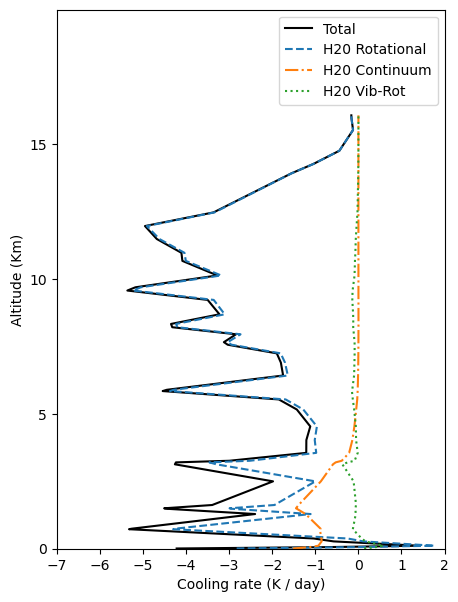

In [43]:
fig, ax  = plt.subplots(figsize = (5, 7))

ax.plot(df['cr_nc_all'], df['hght'] * 1e-3, linestyle = 'solid', color = 'k', label = 'Total')
ax.plot(df['cr_nc_rot'], df['hght'] * 1e-3, linestyle =  'dashed', label = 'H20 Rotational')
ax.plot(df['cr_nc_cont'], df['hght'] * 1e-3, linestyle = 'dashdot', label = 'H20 Continuum')
ax.plot(df['cr_nc_vib'], df['hght'] * 1e-3, linestyle = 'dotted', label = 'H20 Vib-Rot')

# Eixo Y
ax.set_yticks([0, 5, 10, 15])
ax.set_ylim(0, 20)

# Eixo X
left, right = ax.get_xlim()
ax.set_xticks(np.arange(-20, 20, 1))
ax.set_xlim(-7, 2)

# Textos
ax.set_ylabel("Altitude (Km)")
ax.set_xlabel("Cooling rate (K / day)")

# Legenda
plt.legend()

plt.show()

In [44]:
pd.DataFrame.from_dict(df).to_csv('taxa_resfriamento_sbgl1.csv', index = 0)